# HDD 3Hz dataset preparation
Scan -> split (by session) -> build sparse/dense indices -> compute train-only normalization -> sanity checks.

Notes:
- Sparse = hop=3 (1s stride): usually used for encoder training.
- Dense = hop=1 (0.33s stride): used for embedding extraction + segmentation.
- Binary channels (lturn/rturn) are kept as 0/1 (not standardized).


In [3]:
from pathlib import Path
import json
import numpy as np
from hdd_dataset import (
    CHANNEL_NAMES,
    FS_HZ,
    DEFAULT_WINDOW,
    DEFAULT_HOP_TRAIN,
    DEFAULT_HOP_INFER,
    HDDWindowDataset,
    build_session_splits,
    build_window_index,
    compute_normalization,
    scan_dataset,
)

sensor_dir = Path('20200710_sensors/sensor')
label_dir = Path('20200710_labels/target')
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)

window = DEFAULT_WINDOW
hop_sparse = DEFAULT_HOP_TRAIN  # hop=3 (1s stride)
hop_dense = DEFAULT_HOP_INFER  # hop=1 (0.33s stride)
SEED = 123

lturn_idx = CHANNEL_NAMES.index('lturn')
rturn_idx = CHANNEL_NAMES.index('rturn')


In [4]:
# 1) Dataset scan and validation
summary = scan_dataset(sensor_dir, label_dir, window=window)
scan_path = artifacts_dir / 'scan_summary.json'
scan_path.write_text(json.dumps(summary, indent=2))
print(f'Summary saved to {scan_path}')


Sessions with sensors+labels: 137
Lengths (frames): min 792, max 30495, mean 8199.96
Total duration: 6241.08 minutes
Label inventory: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Summary saved to artifacts\scan_summary.json


In [5]:
# 2) Session-level splits (by session_id only; fixed seed)
session_ids = sorted(summary['per_session_label_counts'].keys())
splits = build_session_splits(session_ids, seed=SEED)
split_path = artifacts_dir / 'splits.json'
split_path.write_text(json.dumps(splits, indent=2))
print(f'Splits saved to {split_path}')
print({k: len(v) for k, v in splits.items() if k != 'seed'})


Splits saved to artifacts\splits.json
{'train': 95, 'val': 20, 'test': 22}


In [6]:
# 3) Build window indices
# sparse = hop=3 (training stride)
# dense  = hop=1 (dense inference/segmentation stride)
index_paths = {}
for split_name, ids in splits.items():
    if split_name == 'seed':
        continue
    idx_sparse = build_window_index(ids, sensor_dir, window=window, hop=hop_sparse)
    idx_dense = build_window_index(ids, sensor_dir, window=window, hop=hop_dense)
    sparse_path = artifacts_dir / f'index_{split_name}_sparse.jsonl'
    dense_path = artifacts_dir / f'index_{split_name}_dense.jsonl'
    with sparse_path.open('w', encoding='utf-8') as f:
        for rec in idx_sparse:
            f.write(json.dumps(rec) + '\n')
    with dense_path.open('w', encoding='utf-8') as f:
        for rec in idx_dense:
            f.write(json.dumps(rec) + '\n')
    index_paths[split_name] = {'sparse': sparse_path, 'dense': dense_path}
    print(f"{split_name}: sparse={len(idx_sparse)} dense={len(idx_dense)}")


train: sparse=254334 dense=762894
val: sparse=76350 dense=229029
test: sparse=43055 dense=129143


In [7]:
# 4) Normalization (train sessions only)
normalization = compute_normalization(splits['train'], sensor_dir)
norm_path = artifacts_dir / 'normalization.json'
norm_path.write_text(json.dumps(normalization, indent=2))
print(f'Normalization saved to {norm_path}')
print('binary_channels:', normalization.get('binary_channels'))
print('non_normalized_channels:', normalization.get('non_normalized_channels'))


Normalization saved to artifacts\normalization.json
binary_channels: ['lturn', 'rturn']
non_normalized_channels: ['lturn', 'rturn']


In [8]:
# 5) Confirm lturn/rturn remain {0,1} after normalization
ds = HDDWindowDataset(
    index_paths['train']['sparse'],
    sensor_dir=sensor_dir,
    label_dir=label_dir,
    window=window,
    normalization=normalization,
    return_label=False,
)
rng = np.random.default_rng(0)
for idx in rng.choice(len(ds), size=5, replace=False):
    x, meta = ds[int(idx)]
    u_l = np.unique(x[:, lturn_idx]).tolist()
    u_r = np.unique(x[:, rturn_idx]).tolist()
    assert set(u_l).issubset({0.0, 1.0})
    assert set(u_r).issubset({0.0, 1.0})
    print(f"idx={idx} session={meta['session_id']} t_end={meta['t_end']} lturn_unique={u_l} rturn_unique={u_r}")


idx=161999 session=201704101354 t_end=9569 lturn_unique=[1.0] rturn_unique=[0.0]
idx=129998 session=201703061353 t_end=383 lturn_unique=[0.0] rturn_unique=[0.0, 1.0]
idx=68615 session=201704131047 t_end=2498 lturn_unique=[0.0] rturn_unique=[0.0]
idx=78291 session=201706081335 t_end=9914 lturn_unique=[0.0, 1.0] rturn_unique=[0.0]
idx=216339 session=201702271123 t_end=296 lturn_unique=[0.0] rturn_unique=[0.0]


In [9]:
# 6) Quick dataset sanity check (shapes + labels)
train_dataset = HDDWindowDataset(
    index_paths['train']['sparse'],
    sensor_dir=sensor_dir,
    label_dir=label_dir,
    window=window,
    normalization=normalization,
    return_label=True,
)
print('Train windows:', len(train_dataset))
x0, y0, meta0 = train_dataset[0]
print('Window shape:', x0.shape)
print('Label at t_end:', y0)
print('Metadata:', meta0)


Train windows: 254334
Window shape: (18, 8)
Label at t_end: 0
Metadata: {'session_id': '201706071752', 't_end': 17}


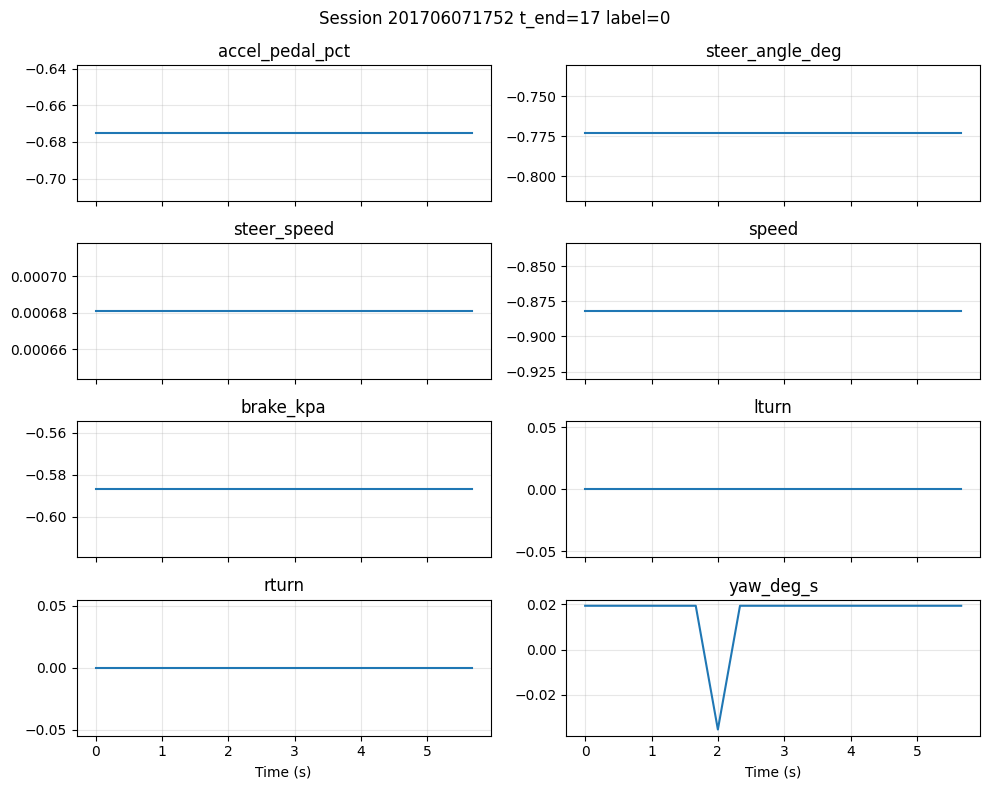

In [10]:
# 7) Plot a single normalized window for sanity
import matplotlib.pyplot as plt
time_axis = np.arange(x0.shape[0]) / FS_HZ
fig, axes = plt.subplots(4, 2, figsize=(10, 8), sharex=True)
for i, ax in enumerate(axes.flat):
    ax.plot(time_axis, x0[:, i])
    ax.set_title(CHANNEL_NAMES[i])
    ax.grid(True, alpha=0.3)
axes[-1, 0].set_xlabel('Time (s)')
axes[-1, 1].set_xlabel('Time (s)')
fig.suptitle(f"Session {meta0['session_id']} t_end={meta0['t_end']} label={y0}")
plt.tight_layout()
plt.show()
